# Membership Trends Analysis

**Membership Performance Dashboard for Leadership**

This analysis provides comprehensive insights into membership growth, retention, and revenue trends to support strategic decision-making for membership programs.

## Analysis Objectives
- Track membership growth and acquisition trends
- Analyze membership retention and churn patterns
- Evaluate revenue performance by membership level
- Identify opportunities for membership optimization

⚠️ **SAFETY NOTE**: This notebook contains only read-only operations for safety.
Database-modifying operations are commented out to prevent accidental changes.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from neon_crm import NeonClient

# Configure visualization style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Initialize client
client = NeonClient(
    org_id=os.getenv("NEON_ORG_ID"),
    api_key=os.getenv("NEON_API_KEY"),
)

print(f"🚀 Neon CRM client initialized for membership trends analysis")
print(f"📊 Analysis date: {datetime.now().strftime('%B %d, %Y')}")
print(f"Environment: {client.environment}")

🚀 Neon CRM client initialized for membership trends analysis
📊 Analysis date: September 26, 2025
Environment: production


## 1. Data Collection: Membership Information

Collecting comprehensive membership data for trend analysis.

In [2]:
def collect_membership_data(client, years_back=3):
    """Collect membership data for trends analysis."""

    print(f"📥 Collecting membership data for the past {years_back} years...")

    # Calculate date range
    end_date = datetime.now()
    start_date = end_date.replace(year=end_date.year - years_back)

    print(f"📅 Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    memberships = []

    # First, get all accounts to find those with memberships
    try:
        account_search = {
            "searchFields": [
                {"field": "Account Type", "operator": "EQUAL", "value": "INDIVIDUAL"}
            ],
            "outputFields": [
                "Account ID", "First Name", "Last Name", "Email 1",
                "City", "State/Province", "Account Created Date/Time"
            ],
            "pagination": {"currentPage": 0, "pageSize": 200}
        }

        all_accounts = list(client.accounts.search(account_search, validate=False))
        print(f"✅ Found {len(all_accounts)} accounts to check for memberships")

        accounts = all_accounts
        print(f"📊 Analyzing memberships for {len(accounts)}")

        # Check each account for memberships
        for i, account in enumerate(accounts):
            account_id = account.get('Account ID')
            if account_id:
                try:
                    # Get this account's membership history
                    account_memberships = client.get(f"/accounts/{account_id}/memberships")
                    if account_memberships and isinstance(account_memberships, list):
                        memberships.extend(account_memberships)
                    elif account_memberships and isinstance(account_memberships, dict):
                        if 'memberships' in account_memberships:
                            memberships.extend(account_memberships['memberships'])
                        else:
                            memberships.append(account_memberships)

                except Exception as e:
                    continue

            # Progress indicator
            if (i + 1) % 25 == 0:
                print(f"   Processed {i + 1}/{len(accounts)} accounts, found {len(memberships)} memberships")

        print(f"✅ Collected {len(memberships)} membership records from {len(accounts)} accounts")

    except Exception as e:
        print(f"❌ Error collecting membership data: {e}")
        return None, None, None, None

    # Get membership levels
    try:
        membership_levels = client.memberships.get_levels()
        print(f"✅ Retrieved {len(membership_levels)} membership levels")
    except Exception as e:
        print(f"❌ Error collecting membership levels: {e}")
        membership_levels = []

    # Get membership terms
    try:
        membership_terms = client.memberships.get_terms()
        print(f"✅ Retrieved {len(membership_terms)} membership terms")
    except Exception as e:
        print(f"❌ Error collecting membership terms: {e}")
        membership_terms = []

    member_accounts = all_accounts if 'all_accounts' in locals() else []

    return memberships, membership_levels, membership_terms, member_accounts

# Collect the data
memberships_raw, levels_raw, terms_raw, accounts_raw = collect_membership_data(client, years_back=3)

📥 Collecting membership data for the past 3 years...
📅 Date range: 2022-09-26 to 2025-09-26
   Processed 875/3693 accounts, found 624 memberships
   Processed 900/3693 accounts, found 645 memberships
   Processed 925/3693 accounts, found 659 memberships
   Processed 950/3693 accounts, found 676 memberships
   Processed 975/3693 accounts, found 678 memberships
   Processed 1000/3693 accounts, found 692 memberships
   Processed 1025/3693 accounts, found 718 memberships
   Processed 1050/3693 accounts, found 747 memberships
   Processed 1075/3693 accounts, found 773 memberships
   Processed 1100/3693 accounts, found 779 memberships
   Processed 1125/3693 accounts, found 796 memberships
   Processed 1150/3693 accounts, found 820 memberships
   Processed 1175/3693 accounts, found 833 memberships
   Processed 1200/3693 accounts, found 854 memberships
   Processed 1225/3693 accounts, found 862 memberships
   Processed 1250/3693 accounts, found 874 memberships
   Processed 1275/3693 accounts, 

## 2. Data Processing and Feature Engineering

Processing membership data for comprehensive analysis.

In [3]:
def process_membership_data(memberships_raw, levels_raw, terms_raw, accounts_raw):
    """Process membership data for analysis."""
    
    if not memberships_raw:
        print("❌ No membership data available for processing")
        return None, None, None, None
    
    print("🔄 Processing membership data...")
    
    # Convert to DataFrames
    memberships_df = pd.DataFrame(memberships_raw)
    levels_df = pd.DataFrame(levels_raw) if levels_raw else pd.DataFrame()
    terms_df = pd.DataFrame(terms_raw) if terms_raw else pd.DataFrame()
    accounts_df = pd.DataFrame(accounts_raw) if accounts_raw else pd.DataFrame()
    
    # Process membershipLevel column if it contains dictionaries
    if 'membershipLevel' in memberships_df.columns:
        first_level = memberships_df['membershipLevel'].iloc[0] if len(memberships_df) > 0 else None
        if isinstance(first_level, dict):
            if 'name' in first_level:
                memberships_df['membershipLevelName'] = memberships_df['membershipLevel'].apply(
                    lambda x: x.get('name') if isinstance(x, dict) else str(x)
                )
            elif 'id' in first_level:
                memberships_df['membershipLevelName'] = memberships_df['membershipLevel'].apply(
                    lambda x: x.get('id') if isinstance(x, dict) else str(x)
                )
            else:
                memberships_df['membershipLevelName'] = memberships_df['membershipLevel'].apply(
                    lambda x: str(x) if isinstance(x, dict) else str(x)
                )
        else:
            memberships_df['membershipLevelName'] = memberships_df['membershipLevel']
    
    # Process membershipTerm column if it exists and contains dictionaries
    if 'membershipTerm' in memberships_df.columns:
        first_term = memberships_df['membershipTerm'].iloc[0] if len(memberships_df) > 0 else None
        if isinstance(first_term, dict):
            if 'name' in first_term:
                memberships_df['membershipTermName'] = memberships_df['membershipTerm'].apply(
                    lambda x: x.get('name') if isinstance(x, dict) else str(x)
                )
            elif 'id' in first_term:
                memberships_df['membershipTermName'] = memberships_df['membershipTerm'].apply(
                    lambda x: x.get('id') if isinstance(x, dict) else str(x)
                )
            else:
                memberships_df['membershipTermName'] = memberships_df['membershipTerm'].apply(
                    lambda x: str(x) if isinstance(x, dict) else str(x)
                )
        else:
            memberships_df['membershipTermName'] = memberships_df['membershipTerm']
    
    # Data cleaning for memberships
    date_columns = ['enrollmentDate', 'startDate', 'endDate', 'lastTransactionDate', 'transactionDate', 'termStartDate', 'termEndDate']
    for col in date_columns:
        if col in memberships_df.columns:
            memberships_df[col] = pd.to_datetime(memberships_df[col], errors='coerce')
    
    # Numeric conversions
    numeric_columns = ['accountId', 'membershipId', 'fee']
    for col in numeric_columns:
        if col in memberships_df.columns:
            memberships_df[col] = pd.to_numeric(memberships_df[col], errors='coerce')
    
    # Calculate membership metrics
    current_date = datetime.now()
    
    # Membership status analysis using termEndDate
    if 'termEndDate' in memberships_df.columns:
        memberships_df['is_active'] = memberships_df['termEndDate'] >= current_date
        memberships_df['days_until_expiry'] = (
            memberships_df['termEndDate'] - current_date
        ).dt.days
    else:
        memberships_df['is_active'] = True
        memberships_df['days_until_expiry'] = None
    
    # Membership duration
    if 'termStartDate' in memberships_df.columns and 'termEndDate' in memberships_df.columns:
        memberships_df['membership_duration_days'] = (
            memberships_df['termEndDate'] - memberships_df['termStartDate']
        ).dt.days
    
    # Time since enrollment using transactionDate
    if 'transactionDate' in memberships_df.columns:
        memberships_df['days_since_enrollment'] = (
            current_date - memberships_df['transactionDate']
        ).dt.days
    
    # Add enrollment year and month for trend analysis
    if 'transactionDate' in memberships_df.columns:
        memberships_df['enrollment_year'] = memberships_df['transactionDate'].dt.year
        memberships_df['enrollment_month'] = memberships_df['transactionDate'].dt.month
        memberships_df['enrollment_year_month'] = memberships_df['transactionDate'].dt.to_period('M')
    
    # Merge with account data
    if not accounts_df.empty:
        accounts_df['Account ID'] = pd.to_numeric(accounts_df['Account ID'], errors='coerce')
        memberships_df = memberships_df.merge(
            accounts_df,
            left_on='accountId',
            right_on='Account ID',
            how='left'
        )
    
    print(f"✅ Processed {len(memberships_df)} membership records")
    
    # Create summary statistics
    summary_stats = {
        'total_memberships': len(memberships_df),
        'active_memberships': memberships_df['is_active'].sum() if 'is_active' in memberships_df.columns else 0,
        'unique_members': memberships_df['accountId'].nunique(),
        'revenue_total': memberships_df['fee'].sum() if 'fee' in memberships_df.columns else 0
    }
    
    print(f"\n📊 Summary Statistics:")
    for key, value in summary_stats.items():
        print(f"   {key.replace('_', ' ').title()}: {value:,}")
    
    return memberships_df, levels_df, terms_df, summary_stats

# Process the data
if memberships_raw:
    memberships_df, levels_df, terms_df, summary_stats = process_membership_data(
        memberships_raw, levels_raw, terms_raw, accounts_raw
    )
else:
    print("⚠️ Skipping processing - no membership data available")
    memberships_df, levels_df, terms_df, summary_stats = None, None, None, None

🔄 Processing membership data...
✅ Processed 2757 membership records

📊 Summary Statistics:
   Total Memberships: 2,757
   Active Memberships: 424
   Unique Members: 988
   Revenue Total: 43,213.0


## 3. Analysis Functions

In [4]:
def analyze_membership_growth(memberships_df):
    """Analyze membership growth trends and patterns."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for growth analysis")
        return None
    
    print("📈 Analyzing membership growth trends...")
    
    growth_analysis = {}
    
    # Use transactionDate or termStartDate for enrollment analysis
    date_column = None
    if 'transactionDate' in memberships_df.columns:
        date_column = 'transactionDate'
    elif 'termStartDate' in memberships_df.columns:
        date_column = 'termStartDate'
    
    if date_column:
        # Convert to datetime
        memberships_df[date_column] = pd.to_datetime(memberships_df[date_column], errors='coerce')
        valid_data = memberships_df[memberships_df[date_column].notna()].copy()
        
        if not valid_data.empty:
            # Create enrollment metrics
            valid_data['enrollment_year'] = valid_data[date_column].dt.year
            valid_data['enrollment_month'] = valid_data[date_column].dt.month
            valid_data['enrollment_year_month'] = valid_data[date_column].dt.to_period('M')
            
            # Monthly enrollment trends
            monthly_enrollments = valid_data.groupby('enrollment_year_month').size()
            monthly_enrollments.index = monthly_enrollments.index.to_timestamp()
            growth_analysis['monthly_enrollments'] = monthly_enrollments
            
            print(f"✓ Monthly enrollment trends calculated ({len(monthly_enrollments)} months)")
            
            # Annual growth rates
            annual_enrollments = valid_data.groupby('enrollment_year').size()
            annual_growth_rate = annual_enrollments.pct_change() * 100
            growth_analysis['annual_enrollments'] = annual_enrollments
            growth_analysis['annual_growth_rate'] = annual_growth_rate
            
            print(f"✓ Annual growth rates calculated")
            print(f"   Years covered: {annual_enrollments.index.min()} - {annual_enrollments.index.max()}")
            
            # Cumulative membership growth
            cumulative_growth = monthly_enrollments.cumsum()
            growth_analysis['cumulative_growth'] = cumulative_growth
            print(f"✓ Cumulative growth trend calculated")
    
    # Membership level analysis - use processed membershipLevelName
    if 'membershipLevelName' in memberships_df.columns:
        level_distribution = memberships_df['membershipLevelName'].value_counts()
        growth_analysis['level_distribution'] = level_distribution
        
        print(f"✓ Membership level distribution analyzed")
        print(f"   Top level: {level_distribution.index[0] if len(level_distribution) > 0 else 'N/A'}")
    
    # Geographic distribution
    if 'State/Province' in memberships_df.columns:
        geographic_distribution = memberships_df['State/Province'].value_counts().head(10)
        growth_analysis['geographic_distribution'] = geographic_distribution
        
        print(f"✓ Geographic distribution analyzed")
        print(f"   Top state: {geographic_distribution.index[0] if len(geographic_distribution) > 0 else 'N/A'}")
    
    # Revenue analysis - use the processed date column
    if 'fee' in memberships_df.columns and date_column and 'valid_data' in locals() and not valid_data.empty:
        monthly_revenue = valid_data.groupby('enrollment_year_month')['fee'].sum()
        monthly_revenue.index = monthly_revenue.index.to_timestamp()
        growth_analysis['monthly_revenue'] = monthly_revenue
        
        print(f"✓ Monthly revenue trends calculated")
    
    return growth_analysis

def analyze_retention_churn(memberships_df):
    """Analyze membership retention and churn patterns."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for retention analysis")
        return None
    
    print("🔄 Analyzing membership retention and churn...")
    
    retention_analysis = {}
    current_date = datetime.now()
    
    # Overall retention metrics
    if 'is_active' in memberships_df.columns:
        total_memberships = len(memberships_df)
        active_memberships = memberships_df['is_active'].sum()
        retention_rate = (active_memberships / total_memberships) * 100
        
        retention_analysis['total_memberships'] = total_memberships
        retention_analysis['active_memberships'] = active_memberships
        retention_analysis['retention_rate'] = retention_rate
        
        print(f"✓ Overall retention rate: {retention_rate:.1f}%")
    
    # Expiry analysis using termEndDate
    if 'termEndDate' in memberships_df.columns:
        memberships_df['termEndDate'] = pd.to_datetime(memberships_df['termEndDate'], errors='coerce')
        
        # Calculate days until expiry
        memberships_df['days_until_expiry'] = (
            memberships_df['termEndDate'] - current_date
        ).dt.days
        
        # Filter out None values before using pd.cut
        valid_expiry_data = memberships_df[memberships_df['days_until_expiry'].notna()]
        
        if len(valid_expiry_data) > 0:
            # Categorize by expiry timeline
            expiry_bins = [-np.inf, 0, 30, 90, 180, 365, np.inf]
            expiry_labels = ['Expired', 'Expires Soon (30d)', 'Expires in 31-90d', 
                            'Expires in 91-180d', 'Expires in 181-365d', 'Long-term Active']
            
            valid_expiry_data = valid_expiry_data.copy()
            valid_expiry_data['expiry_category'] = pd.cut(
                valid_expiry_data['days_until_expiry'], 
                bins=expiry_bins, 
                labels=expiry_labels
            )
            
            expiry_distribution = valid_expiry_data['expiry_category'].value_counts()
            retention_analysis['expiry_distribution'] = expiry_distribution
            
            print(f"✓ Expiry distribution analyzed ({len(valid_expiry_data)} records with valid expiry dates)")
            
            # Identify at-risk memberships (expiring within 30 days)
            at_risk = valid_expiry_data[
                (valid_expiry_data['days_until_expiry'] > 0) & 
                (valid_expiry_data['days_until_expiry'] <= 30)
            ]
            retention_analysis['at_risk_count'] = len(at_risk)
            
            print(f"✓ At-risk memberships (expiring within 30 days): {len(at_risk)}")
        else:
            print("⚠️ No valid expiry data available for analysis")
            retention_analysis['at_risk_count'] = 0
    else:
        print("⚠️ No termEndDate column available for expiry analysis")
        retention_analysis['at_risk_count'] = 0
    
    # Retention by membership level - use processed membershipLevelName
    if 'membershipLevelName' in memberships_df.columns and 'is_active' in memberships_df.columns:
        level_retention = memberships_df.groupby('membershipLevelName').agg({
            'is_active': ['count', 'sum']
        })
        level_retention.columns = ['total', 'active']
        level_retention['retention_rate'] = (
            level_retention['active'] / level_retention['total'] * 100
        ).round(1)
        
        retention_analysis['level_retention'] = level_retention
        print(f"✓ Retention rates by membership level calculated")
    
    return retention_analysis

def analyze_membership_revenue(memberships_df, levels_df):
    """Analyze membership revenue trends and performance."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for revenue analysis")
        return None
    
    print("💰 Analyzing membership revenue...")
    
    revenue_analysis = {}
    
    # Total revenue metrics
    if 'fee' in memberships_df.columns:
        total_revenue = memberships_df['fee'].sum()
        avg_revenue_per_member = memberships_df['fee'].mean()
        
        revenue_analysis['total_revenue'] = total_revenue
        revenue_analysis['avg_revenue_per_member'] = avg_revenue_per_member
        
        print(f"✓ Total membership revenue: ${total_revenue:,.2f}")
        print(f"✓ Average revenue per membership: ${avg_revenue_per_member:.2f}")
    
    # Revenue by membership level - use processed membershipLevelName
    if 'membershipLevelName' in memberships_df.columns and 'fee' in memberships_df.columns:
        level_revenue = memberships_df.groupby('membershipLevelName').agg({
            'fee': ['sum', 'mean', 'count']
        }).round(2)
        level_revenue.columns = ['total_revenue', 'avg_fee', 'member_count']
        level_revenue['revenue_percentage'] = (
            level_revenue['total_revenue'] / level_revenue['total_revenue'].sum() * 100
        ).round(1)
        
        revenue_analysis['level_revenue'] = level_revenue
        print(f"✓ Revenue analysis by membership level completed")
    
    # Use transaction date for monthly revenue trends
    date_column = None
    if 'transactionDate' in memberships_df.columns:
        date_column = 'transactionDate'
    elif 'termStartDate' in memberships_df.columns:
        date_column = 'termStartDate'
    
    if date_column and 'fee' in memberships_df.columns:
        # Convert to datetime and filter valid data
        memberships_df[date_column] = pd.to_datetime(memberships_df[date_column], errors='coerce')
        valid_data = memberships_df[memberships_df[date_column].notna()].copy()
        
        if not valid_data.empty:
            # Create year-month periods
            valid_data['enrollment_year_month'] = valid_data[date_column].dt.to_period('M')
            valid_data['enrollment_year'] = valid_data[date_column].dt.year
            
            # Monthly revenue trends
            monthly_revenue = valid_data.groupby('enrollment_year_month')['fee'].sum()
            monthly_revenue.index = monthly_revenue.index.to_timestamp()
            
            # Calculate growth rates
            monthly_growth_rate = monthly_revenue.pct_change() * 100
            
            revenue_analysis['monthly_revenue'] = monthly_revenue
            revenue_analysis['monthly_growth_rate'] = monthly_growth_rate
            
            print(f"✓ Monthly revenue trends calculated")
            
            # Annual revenue comparison
            annual_revenue = valid_data.groupby('enrollment_year')['fee'].sum()
            annual_revenue_growth = annual_revenue.pct_change() * 100
            
            revenue_analysis['annual_revenue'] = annual_revenue
            revenue_analysis['annual_revenue_growth'] = annual_revenue_growth
            
            print(f"✓ Annual revenue comparison completed")
    
    return revenue_analysis

## 4. Run Analysis

In [5]:
# Perform all analyses
if memberships_df is not None:
    growth_analysis = analyze_membership_growth(memberships_df)
    retention_analysis = analyze_retention_churn(memberships_df)
    revenue_analysis = analyze_membership_revenue(memberships_df, levels_df)
else:
    print("⚠️ Skipping analysis - no data available")
    growth_analysis = None
    retention_analysis = None
    revenue_analysis = None

📈 Analyzing membership growth trends...
✓ Monthly enrollment trends calculated (117 months)
✓ Annual growth rates calculated
   Years covered: 2000 - 2026
✓ Cumulative growth trend calculated
✓ Membership level distribution analyzed
   Top level: Activist Family
✓ Geographic distribution analyzed
   Top state: WI
✓ Monthly revenue trends calculated
🔄 Analyzing membership retention and churn...
✓ Overall retention rate: 15.4%
✓ Expiry distribution analyzed (2756 records with valid expiry dates)
✓ At-risk memberships (expiring within 30 days): 33
✓ Retention rates by membership level calculated
💰 Analyzing membership revenue...
✓ Total membership revenue: $43,213.00
✓ Average revenue per membership: $15.67
✓ Revenue analysis by membership level completed
✓ Monthly revenue trends calculated
✓ Annual revenue comparison completed


## 5. Visualization Dashboard

📊 Creating membership trends dashboard...


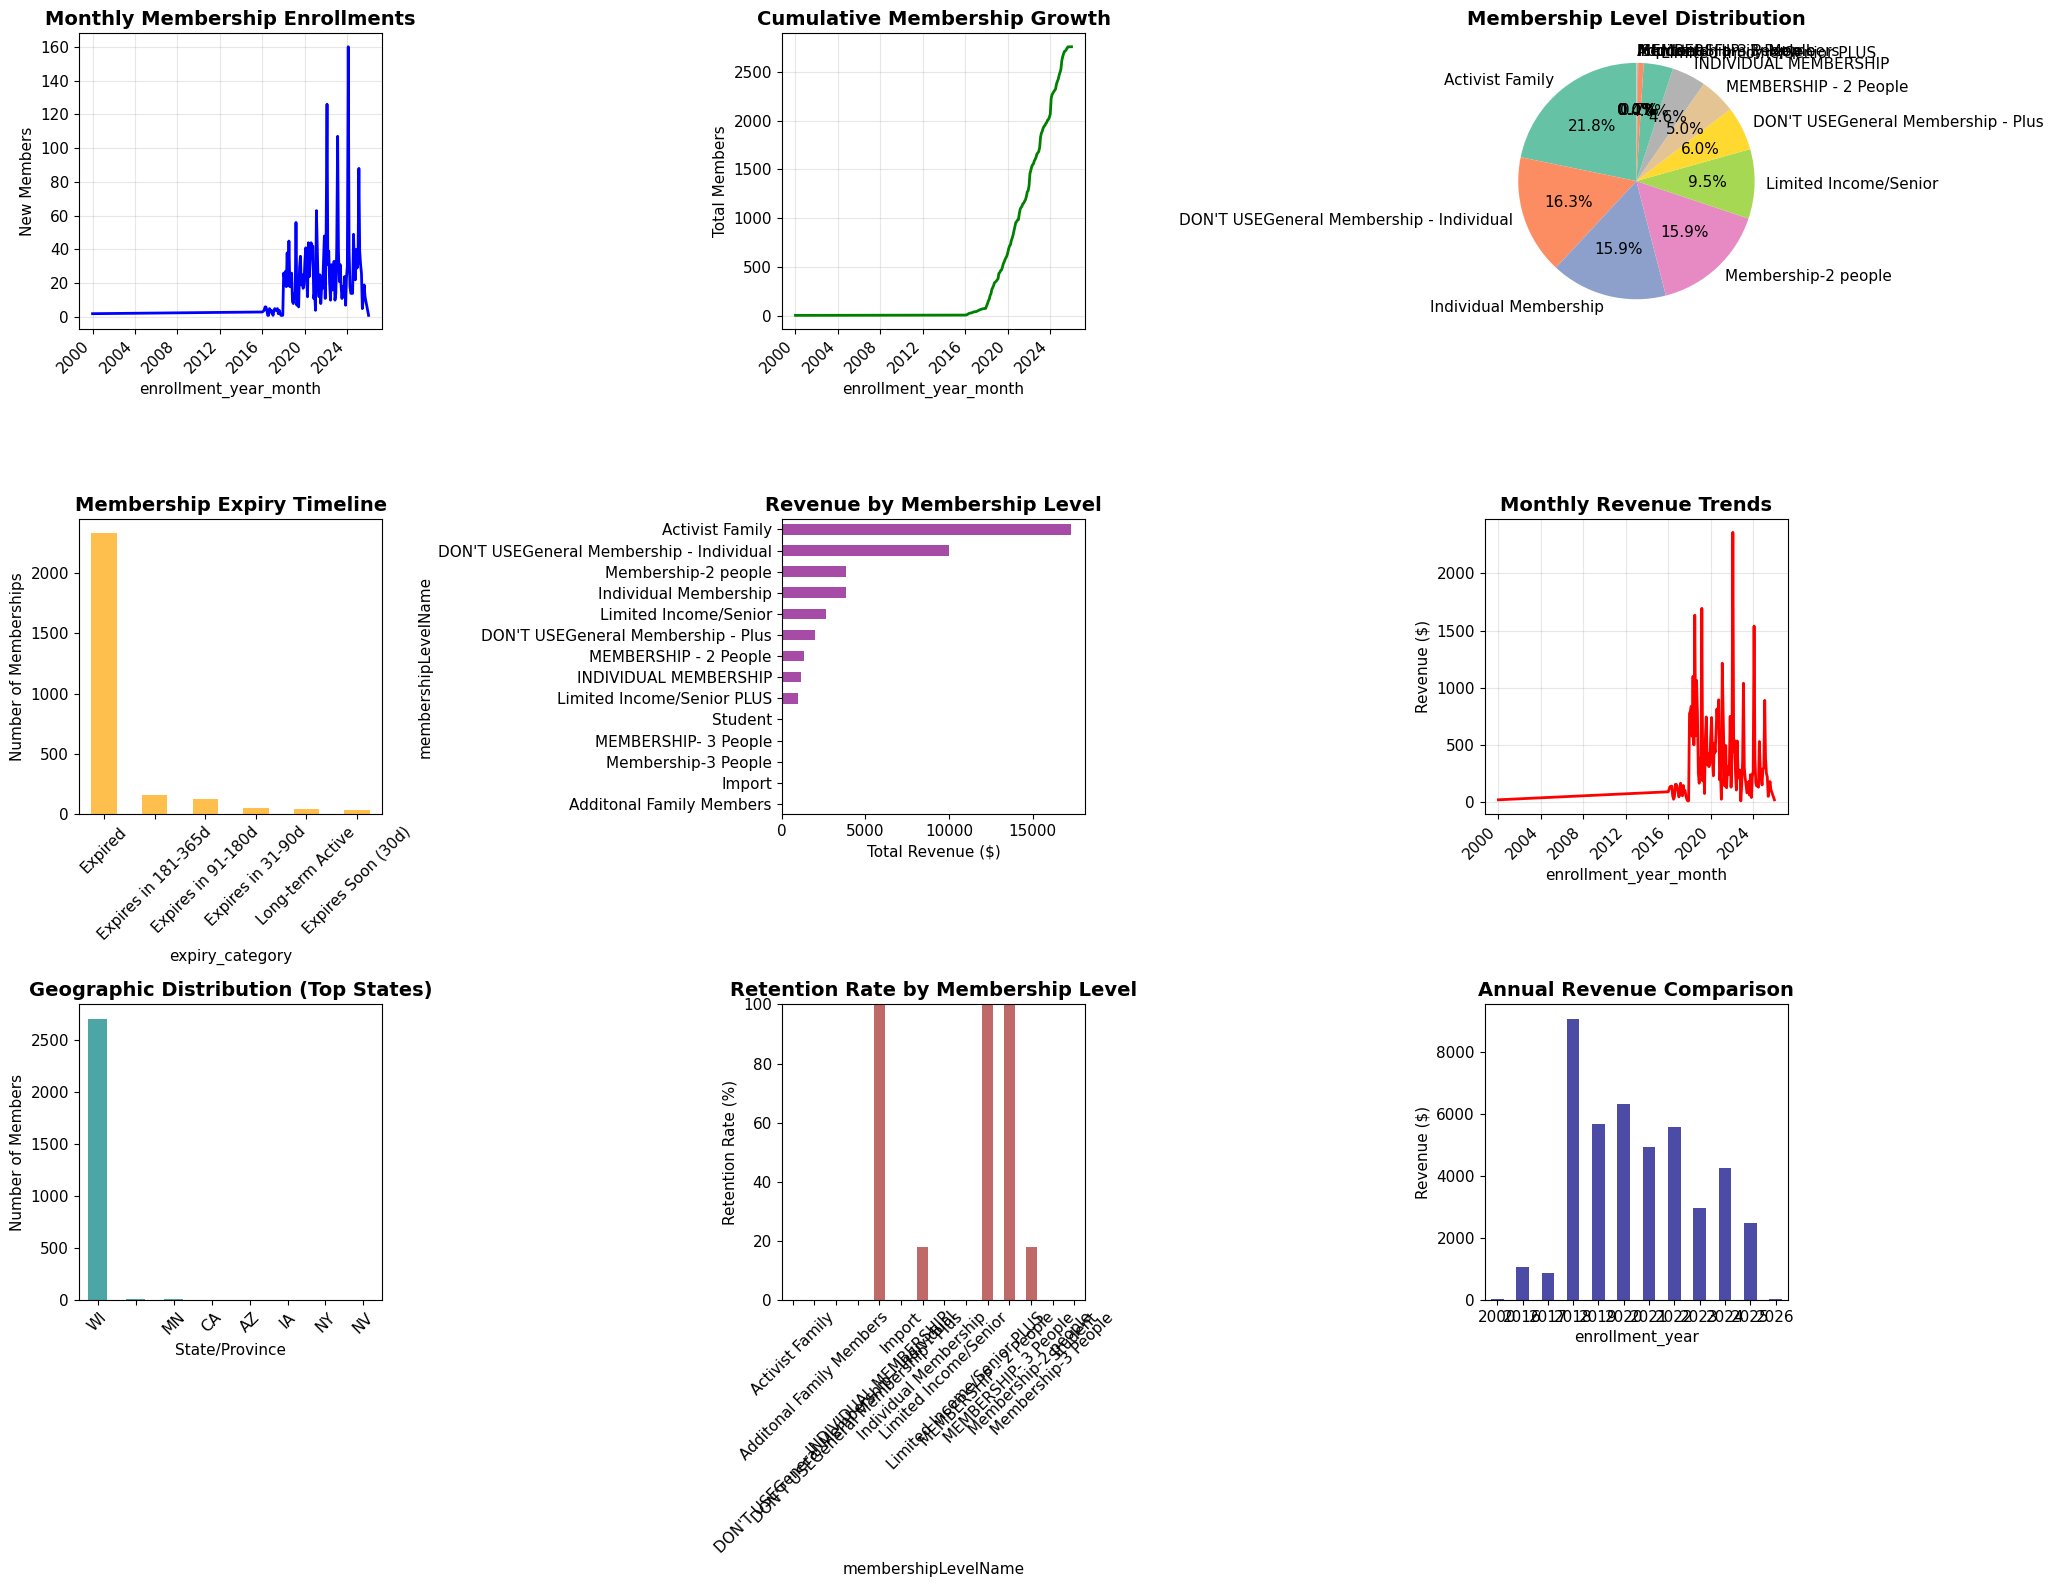

✅ Membership dashboard created and saved as 'membership_trends_dashboard.png'


In [6]:
def create_membership_dashboard(memberships_df, growth_analysis, retention_analysis, revenue_analysis):
    """Create comprehensive membership trends dashboard."""
    
    if memberships_df is None:
        print("❌ No data available for dashboard creation")
        return
    
    print("📊 Creating membership trends dashboard...")
    
    # Create dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Monthly Enrollment Trends
    if growth_analysis and 'monthly_enrollments' in growth_analysis:
        plt.subplot(3, 3, 1)
        growth_analysis['monthly_enrollments'].plot(kind='line', color='blue', linewidth=2)
        plt.title('Monthly Membership Enrollments', fontsize=14, fontweight='bold')
        plt.ylabel('New Members')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 2. Cumulative Growth
    if growth_analysis and 'cumulative_growth' in growth_analysis:
        plt.subplot(3, 3, 2)
        growth_analysis['cumulative_growth'].plot(kind='line', color='green', linewidth=2)
        plt.title('Cumulative Membership Growth', fontsize=14, fontweight='bold')
        plt.ylabel('Total Members')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 3. Membership Level Distribution
    if growth_analysis and 'level_distribution' in growth_analysis:
        plt.subplot(3, 3, 3)
        level_dist = growth_analysis['level_distribution']
        plt.pie(level_dist.values, labels=level_dist.index, autopct='%1.1f%%', startangle=90)
        plt.title('Membership Level Distribution', fontsize=14, fontweight='bold')
    
    # 4. Expiry Timeline Distribution
    if retention_analysis and 'expiry_distribution' in retention_analysis:
        plt.subplot(3, 3, 4)
        expiry_dist = retention_analysis['expiry_distribution']
        expiry_dist.plot(kind='bar', color='orange', alpha=0.7)
        plt.title('Membership Expiry Timeline', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Memberships')
        plt.xticks(rotation=45)
    
    # 5. Revenue by Membership Level
    if revenue_analysis and 'level_revenue' in revenue_analysis:
        plt.subplot(3, 3, 5)
        level_rev = revenue_analysis['level_revenue']['total_revenue'].sort_values(ascending=True)
        level_rev.plot(kind='barh', color='purple', alpha=0.7)
        plt.title('Revenue by Membership Level', fontsize=14, fontweight='bold')
        plt.xlabel('Total Revenue ($)')
    
    # 6. Monthly Revenue Trends
    if revenue_analysis and 'monthly_revenue' in revenue_analysis:
        plt.subplot(3, 3, 6)
        revenue_analysis['monthly_revenue'].plot(kind='line', color='red', linewidth=2)
        plt.title('Monthly Revenue Trends', fontsize=14, fontweight='bold')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 7. Geographic Distribution
    if growth_analysis and 'geographic_distribution' in growth_analysis:
        plt.subplot(3, 3, 7)
        geo_dist = growth_analysis['geographic_distribution'].head(8)
        geo_dist.plot(kind='bar', color='teal', alpha=0.7)
        plt.title('Geographic Distribution (Top States)', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Members')
        plt.xticks(rotation=45)
    
    # 8. Retention Rate by Level
    if retention_analysis and 'level_retention' in retention_analysis:
        plt.subplot(3, 3, 8)
        level_ret = retention_analysis['level_retention']['retention_rate']
        level_ret.plot(kind='bar', color='brown', alpha=0.7)
        plt.title('Retention Rate by Membership Level', fontsize=14, fontweight='bold')
        plt.ylabel('Retention Rate (%)')
        plt.ylim(0, 100)
        plt.xticks(rotation=45)
    
    # 9. Annual Revenue Growth
    if revenue_analysis and 'annual_revenue' in revenue_analysis:
        plt.subplot(3, 3, 9)
        annual_rev = revenue_analysis['annual_revenue']
        annual_rev.plot(kind='bar', color='navy', alpha=0.7)
        plt.title('Annual Revenue Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('/Users/mdassow/development/Neon_CRM_SDK/analysis/membership_trends_dashboard.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Membership dashboard created and saved as 'membership_trends_dashboard.png'")

# Create the dashboard
if memberships_df is not None:
    create_membership_dashboard(memberships_df, growth_analysis, retention_analysis, revenue_analysis)
else:
    print("⚠️ Skipping dashboard creation - no data available")

## 6. New Members by Month Graph

📊 Creating new members by month graph...


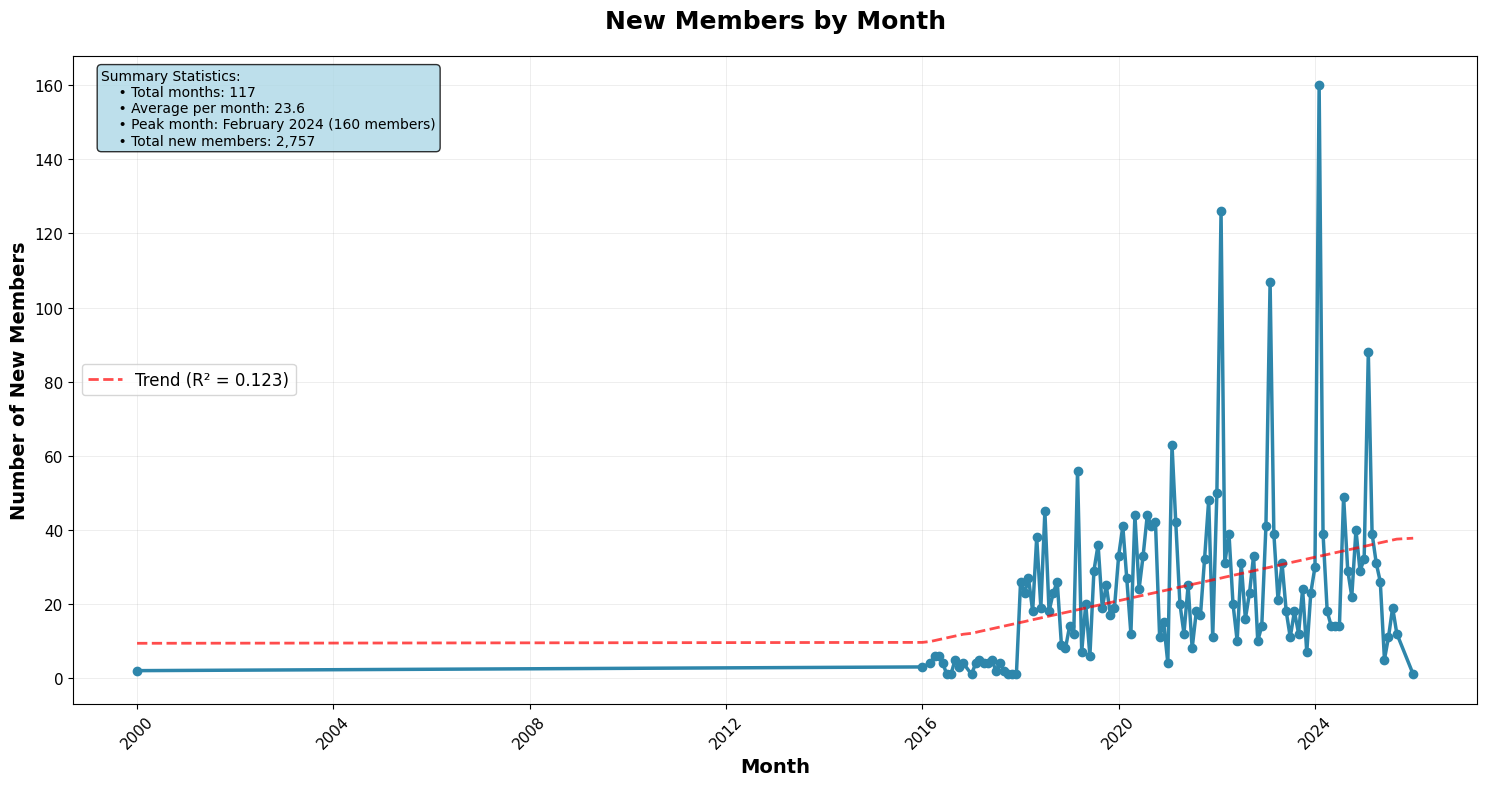

✅ New members by month graph created and saved
📈 Data covers 117 months with an average of 23.6 new members per month


In [7]:
def create_new_members_by_month_graph(memberships_df):
    """Create a focused graph showing new members by month."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for new members graph")
        return
    
    print("📊 Creating new members by month graph...")
    
    # Check if we have transaction date data (which represents enrollment)
    date_column = None
    if 'transactionDate' in memberships_df.columns:
        date_column = 'transactionDate'
    elif 'termStartDate' in memberships_df.columns:
        date_column = 'termStartDate'
    else:
        print("❌ No suitable date column found for new member analysis")
        return
    
    # Convert date column to datetime
    memberships_df[date_column] = pd.to_datetime(memberships_df[date_column], errors='coerce')
    
    # Remove rows with invalid dates
    valid_data = memberships_df[memberships_df[date_column].notna()].copy()
    
    if valid_data.empty:
        print("❌ No valid enrollment dates found")
        return
    
    # Create year-month period for grouping
    valid_data['enrollment_month'] = valid_data[date_column].dt.to_period('M')
    
    # Count new members by month
    monthly_new_members = valid_data.groupby('enrollment_month').size()
    
    # Convert period index to timestamp for better plotting
    monthly_new_members.index = monthly_new_members.index.to_timestamp()
    
    # Create the graph
    plt.figure(figsize=(15, 8))
    
    # Plot line graph
    plt.plot(monthly_new_members.index, monthly_new_members.values, 
             marker='o', linewidth=2.5, markersize=6, color='#2E86AB')
    
    # Add trend line
    x_numeric = range(len(monthly_new_members))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, monthly_new_members.values)
    trend_line = [slope * x + intercept for x in x_numeric]
    plt.plot(monthly_new_members.index, trend_line, '--', color='red', alpha=0.7, linewidth=2, label=f'Trend (R² = {r_value**2:.3f})')
    
    # Formatting
    plt.title('New Members by Month', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Month', fontsize=14, fontweight='bold')
    plt.ylabel('Number of New Members', fontsize=14, fontweight='bold')
    
    # Format x-axis
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add legend
    plt.legend(fontsize=12)
    
    # Add summary statistics as text box
    total_months = len(monthly_new_members)
    avg_per_month = monthly_new_members.mean()
    max_month = monthly_new_members.idxmax().strftime('%B %Y')
    max_value = monthly_new_members.max()
    
    stats_text = f'''Summary Statistics:
    • Total months: {total_months}
    • Average per month: {avg_per_month:.1f}
    • Peak month: {max_month} ({max_value} members)
    • Total new members: {monthly_new_members.sum():,}'''
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             fontsize=10)
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the graph
    plt.savefig('/Users/mdassow/development/Neon_CRM_SDK/analysis/new_members_by_month.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ New members by month graph created and saved")
    print(f"📈 Data covers {total_months} months with an average of {avg_per_month:.1f} new members per month")
    
    # Return the data for further analysis
    return monthly_new_members

# Create the new members by month graph
if memberships_df is not None:
    monthly_data = create_new_members_by_month_graph(memberships_df)
else:
    print("⚠️ Skipping new members graph - no data available")